In [1]:
import time

notebook_start = time.time()

First we will need to install ktrain as it is not included with colab.  The special tail command hides the ugly output.

In [2]:
pip install ktrain &> /dev/null

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import os.path
import ktrain
from ktrain import text

In [4]:
drive_path = '/content/drive/MyDrive/NLP/'

# Natural Language Processing with TensorFlow #

Another avenue of Deep Learning / Artificial Intelligence that is particularly exciting is Natural Language Processing or NLP.  Combined with Computer Vision and voice recognition, artificial intelligence is really starting to feel like the science fiction movies that inspired us as kids.  The project is an overview of the entire NLP workflow.  This illustration provides a good breakdown of the process.

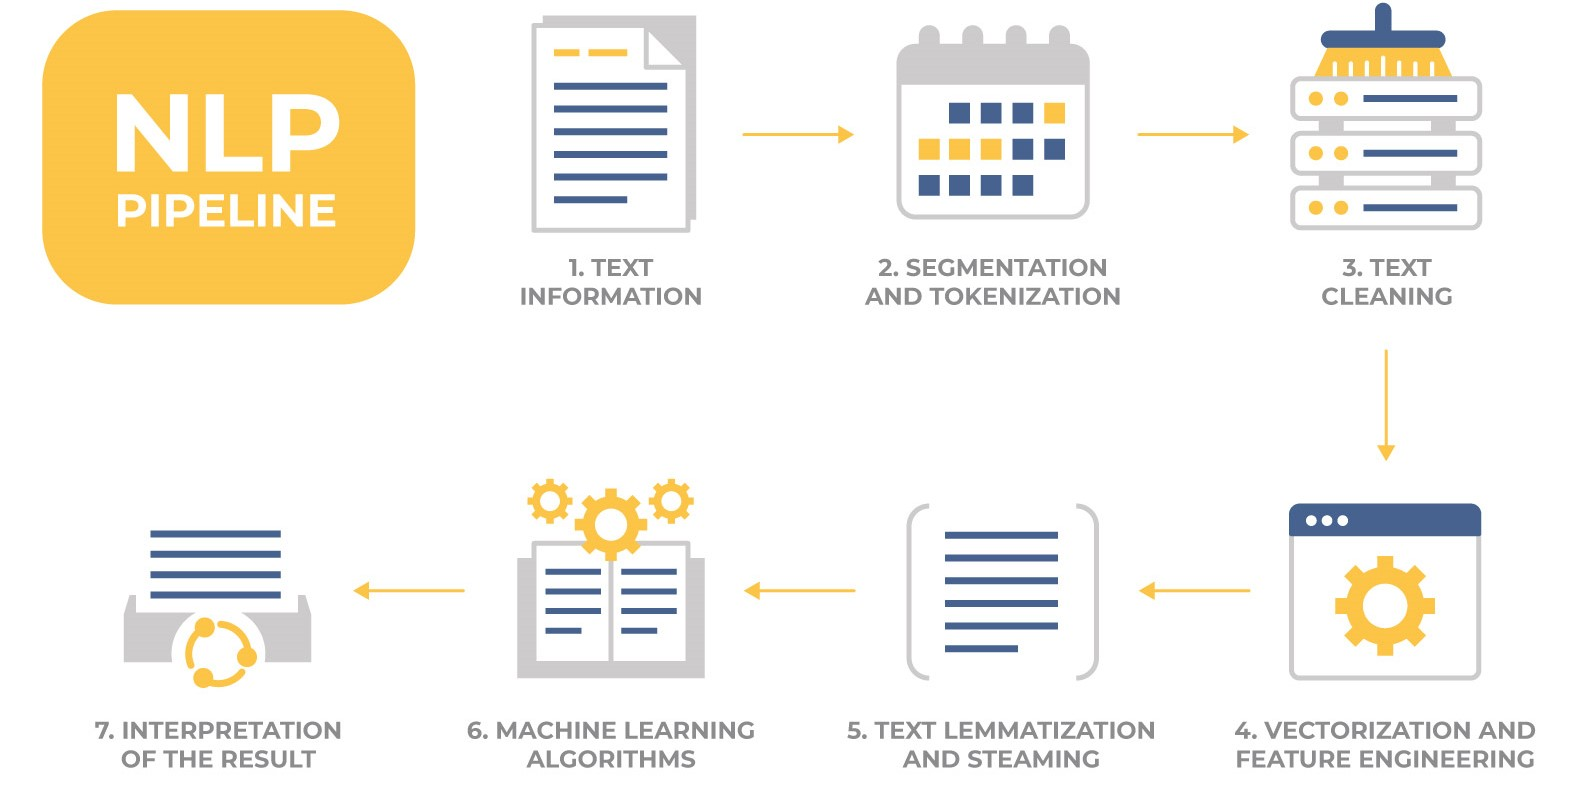

This notebook will explore the fundamentals of NLP using the great IMDB reviews dataset that is included with TensorFlow.  It contains 50,000 reviews labeled as positive or negative to be used for training and testing as well as an additional 50,000 unlabeled reviews to be used for predictions if desired.

To begin, let's start just by building a tokenizer and running a simple deep learning model on it and see how we do for a baseline.  Then we will utilize transfer learning and fine-tuning to really improve our results.  We'll utilize a similar modular code approach to efficient testing as before. Let's dive in.

In [5]:
def load_dataset():
  # Start with loading in the imdb reviews using the tfds workflow
  imdb, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)

  # extract train and test data from tfds
  train_data, test_data = imdb['train'], imdb['test']

  return train_data, test_data

Great, we now have the data loaded and shuffled.  Now we need to preprocess it a bit to get it ready for tokenization.  The list of sentences will need to be converted to numpy arrays.

In [6]:
def tfds_converter(train_data, test_data):
  training_sentences = []
  training_labels = []

  testing_sentences = []
  testing_labels = []

  for s,l in train_data:
    training_sentences.append(str(s.numpy()))
    training_labels.append(l.numpy())

  for s,l in test_data:
    testing_sentences.append(str(s.numpy()))
    testing_labels.append(l.numpy())

  training_labels_final = np.array(training_labels)
  testing_labels_final = np.array(testing_labels)

  return training_sentences, training_labels_final, testing_sentences, testing_labels_final

Now we will utilize the built-in Tokenizer and pad_sequences functions to tokenize the dataset.

In [7]:
def my_tokenizer(training_sentences, testing_sentences, voacb_size, embedding_dim, max_length, trunc_type, oov_tok):
  # create tokenizer and fit to training data using parameters
  tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
  tokenizer.fit_on_texts(training_sentences)
  word_index = tokenizer.word_index
  sequences = tokenizer.texts_to_sequences(training_sentences) # convert sentences into sequences of numbers
  padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type) # pads short reviews to max length

  # tokenize testing data
  testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
  testing_padded = pad_sequences(testing_sequences, maxlen=max_length)

  return padded, testing_padded

Okay perfect, we now have our tokenizer set up and the decoder as well.  We can now feed the preprocessed data into a baseline model.  Let's define that now.

Choosing the right model for the job is one of the fun challenges of data science.  Natural language processing can be very challenging because of the nuance of the english language.  Some words have multiple meanings, and context matters greatly.  The placement of words within a sentence defines their meaning.

To build a model that can recognize this contextual meaning of our words we will use what is called a Recurrent Neural Network.  An RNN is able to pass information learned through to the model, allowing it to learn the sequences and contexts of the words within the sentences.  This is much more powerful for NLP than a traditional deep learning network.  The illustratin below shows a simplified exapmle of this type of architecture.

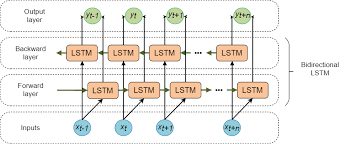

Bear with me on the acronyms for a moment.  To begin, we will use a Gated Recurrent Unit, or GRU.  This is actually a streamlined version of the Long Short-Term Momry algorithm, more commonly referred to as an LSTM.  Because it is slightly watered-down so to speak, it should perform a bit faster on the dataset but may not achieve as high of accuracy.  Let's take a look at the two and compare.

In [8]:
def define_model():
  # Set up simple bi-directional GRU, a version of a recurrent neural network
  model = tf.keras.Sequential([
                              # embedding layer using our parameters
                              tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
                              # Will utilize a simple bi-directional Gated Recurrent Unit (GRU)
                              tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
                              # Now add a hidden layer
                              tf.keras.layers.Dense(6, activation='relu'),
                              # And the output layer, binary because it is positive/negative
                              tf.keras.layers.Dense(1, activation='sigmoid')
  ])
  # show model summary
  model.summary()
  # compile the model using binary crossentropy and the adam optimizer
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model

In [9]:
# Visualize the model
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel('Epochs')
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

In [10]:
# Bring it all together into a test harness
# Set it up with default parameters
def run_test_harness(vocab_size=10000, embedding_dim=16, max_length=120, trunc_type = 'post', oov_tok = '<OOV>', num_epochs=50):
  # Time the run
  start = time.time()
  # Load dataset
  train_data, test_data = load_dataset()
  # convert tfds to numpy array for labels
  training_sentences, training_labels_final, testing_sentences, testing_labels_final = tfds_converter(train_data, test_data)
  # tokenize the dataset
  padded, testing_padded = my_tokenizer(training_sentences, testing_sentences, vocab_size, embedding_dim, max_length, trunc_type, oov_tok)
  # define model
  model = define_model()
  # fit model
  history = model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final),verbose=0)
  # evaluate the model
  _, acc = model.evaluate(testing_padded, testing_labels_final, verbose=0)
  # visualize the learning curves
  plot_graphs(history, 'loss')
  plot_graphs(history, 'accuracy')
  # stop the timer
  end = time.time()
  seconds = end - start
  # output info
  print('> Test Accuracy: %.3f' % (acc * 100))
  print(f'> Test Harness Run Time: {seconds} seconds ({seconds / 60} minutes)')

In [11]:
# Choose parameters 
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type = 'post' # cuts off the back of the review not the front
oov_tok = '<OOV>' # so the model can be used with reviews that contain unseen words

INFO:absl:No config specified, defaulting to first: imdb_reviews/plain_text
INFO:absl:Load dataset info from /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0
INFO:absl:Reusing dataset imdb_reviews (/root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0)
INFO:absl:Constructing tf.data.Dataset for split None, from /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                9600      
_________________________________________________________________
dense (Dense)                (None, 6)                 390       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7         
Total params: 169,997
Trainable params: 169,997
Non-trainable params: 0
_________________________________________________________________


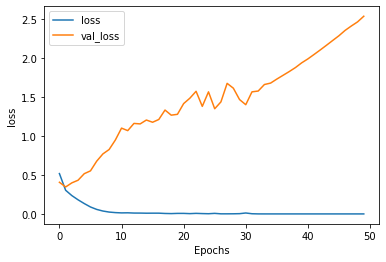

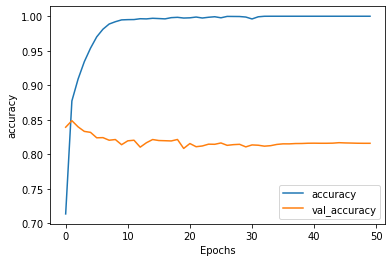

> Test Accuracy: 81.600
> Test Harness Run Time: 605.9542713165283 seconds (10.099237855275472 minutes)


In [12]:
run_test_harness()

Okay great, we have a baseline model!  Let's take a closer look at the results.  Although the performance seems decent at 81%, we can tell by these learning curves there is clear room for improvement. The loss function diverging and skyrocketing is a bad sign, and the clear overfitting as well.  It is also always important to consider how our model performance compares to that of an expert level human.  In this case, someone very familiar with movie reviews would likely achieve a much higher accuracy than 81%, so we know we can do a lot better.  For now, let's take advantage of our test harness and run an LSTM model now.


In [13]:
# LSTM Model
def define_model():
  # Set up simple bi-directional GRU, a version of a recurrent neural network
  model = tf.keras.Sequential([
                              # embedding layer using our parameters
                              tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
                              # Simply change this layer to LSTM and away we go!
                              tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
                              # Now add a hidden layer
                              tf.keras.layers.Dense(6, activation='relu'),
                              # And the output layer, binary because it is positive/negative
                              tf.keras.layers.Dense(1, activation='sigmoid')
  ])
  # show model summary
  model.summary()
  # compile the model using binary crossentropy and the adam optimizer
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model

INFO:absl:No config specified, defaulting to first: imdb_reviews/plain_text
INFO:absl:Load dataset info from /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0
INFO:absl:Reusing dataset imdb_reviews (/root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0)
INFO:absl:Constructing tf.data.Dataset for split None, from /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 16)           160000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                12544     
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 390       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 172,941
Trainable params: 172,941
Non-trainable params: 0
_________________________________________________________________


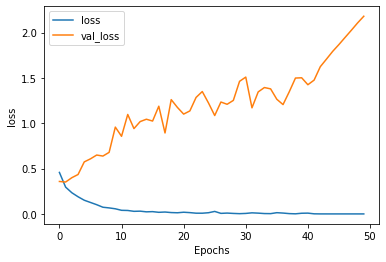

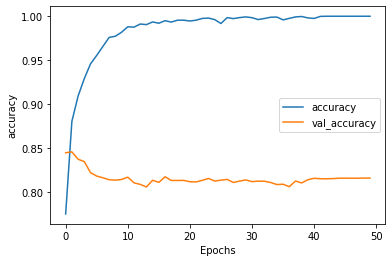

> Test Accuracy: 81.608
> Test Harness Run Time: 629.7469367980957 seconds (10.495782279968262 minutes)


In [14]:
run_test_harness()

- GRU: 81.600% 605.954 second runtime
- LSTM: 81.608% 629.747 second runtime

Great, we now have two simple models to compare.  As expected, the more streamlined GRU model was slightly more efficient with the shorter runtime.  Interestingly, the accuracy performance is almost the same.  This is not always the case, but with our very simple model and relatively straightforward input sequences the GRU was quite effective.  

https://datascience.stackexchange.com/questions/14581/when-to-use-gru-over-lstm

With much larger, more complex problems it is very common that you will need to make a decision between performance and efficiency.  There is no "silver bullet" to answer the question of which model is "best" for the situation.  It always depends on the business case.  There are instances where efficiency will be optimized and you simply need to satisfy a given accuracy threshold, and vice versa.  Certain architectures will apply more favorably to specific situations but not others.

Although the GRU model would be preferable between the two, before we get too far into the weeds let's step back and think about optimization as a concept in terms of NLP.

More specifically, I like to try to use a **data centric** approach to optimization whenever possible compared to a **model centric** approach.  

## Data Centric Development ## 

Think of it this way, there are two fundamentally separate ways to optimize your overall performance.  You can fine-tune the parameters and layers of your algorithm, or you can go get more and better data!  And of course most often a combination of both is key.

In the NLP space, when you consider how many words there are in the English language and the intricate semantics, you would want to train on as large of a corpus (collection of text data) as possible.  And that is a perfect seqway into the next phase of this project, **Transfer Learning**.

# Transfer Learning with BERT #

We will be utilizing the **Bidirectional Encoder Representations from Transformers**, better known as our good friend **BERT**.  This will give an excellent opportunity to utilize **Transfer Learning**, a very powerful technique used in deep learning to fast track progress using previously trained models such as BERT.

BERT is a cutting edge NLP model developed by Jacob Devlin and his team at Google in 2018.  The model was trained on English Wikipedia (2,500M words) and BooksCorpus (800M words).  As we have come to realize, that type of training would take massive compute power and time.  Luckily we can just import the model and run with it!  It is worth noting there are two models of BERT, the base model and the large model.  We will be using the base model.

## Working with BERT and ktrain ##

BERT is great.  A very powerful NLP model pretrained on millions of words and a large variety of contexts make it very effective at deciphering the English language.  

However the downside of BERT and other pretrained NLP models is you need to follow very specific preprocessing steps to use the BERT tokenizer on your train and test data.

That is where **ktrain** comes in.  ktrain is a keras wrapper used to help build, train, optimize, debug, and deploy deep learning models.  ktrain is fully integrated with our good buddy BERT and will make streamline dozens of lines of code into a few easy operations.  Let's take a look. 

One quick note, previously we were building our custom functions to integrate with the tfds workflow.  ktrain is built to utilize the get_file workflow from keras.

https://arxiv.org/abs/1810.04805

https://pypi.org/project/ktrain/

In [15]:
# Data Preprocessing
dataset = tf.keras.utils.get_file(fname = 'aclImdb_v1.tar.gz',
                                  origin = 'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz',
                                  extract = True)

IMDB_DATADIR = os.path.join(os.path.dirname(dataset), 'aclImdb')

In [16]:
print(os.path.dirname(dataset))
print(IMDB_DATADIR)

/root/.keras/datasets
/root/.keras/datasets/aclImdb


In [17]:
# Train Test Split using ktrain text module and the BERT base model preprocessing algorithm
(x_train, y_train), (x_test, y_test), preproc = text.texts_from_folder(datadir = IMDB_DATADIR,
                                                                       classes = ['pos', 'neg'],
                                                                       maxlen = 500,
                                                                       train_test_names = ['train', 'test'],
                                                                       preprocess_mode = 'bert')

detected encoding: utf-8
preprocessing train...
language: en


Is Multi-Label? False
preprocessing test...
language: en


In [18]:
# Build the BERT Model using ktrain text module
model = text.text_classifier(name = 'bert',
                             train_data = (x_train, y_train),
                             preproc = preproc)

Is Multi-Label? False
maxlen is 500
done.


In [19]:
# instantiate the BERT model on our IMDB reviews train and test data set
learner = ktrain.get_learner(model = model,
                             train_data = (x_train, y_train),
                             val_data = (x_test, y_test),
                             batch_size = 6)

ktrain has a lot of useful features for tuning your models.  For this problem we will utilize the fit_onecycle method to adjust the learning rate and momentum as the model trains.  It will increase the learning rate from a base to the maximum for the first half of training, and decrease back to the minimum rate at the end.  This is is a very useful technique and will allow us to train the learner effectively.  Let's see how much better our BERT model performs on the IMDB reviews dataset.  Remember, previously our models reached 81% accuracy and took about 12 minutes to run.

In [20]:
# Time the process
start = time.time()

# Fit the learner with a maximum learning rate and 2 epochs
learner.fit_onecycle(lr = 2e-5, epochs=5)

end = time.time()

seconds = end - start
print(f'> Run Time: {seconds} seconds ({seconds / 60} minutes)')



begin training using onecycle policy with max lr of 2e-05...
Epoch 1/5
4167/4167 [==============================] - 3422s 817ms/step - loss: 0.3703 - accuracy: 0.8230 - val_loss: 0.2147 - val_accuracy: 0.9164
Epoch 2/5
4167/4167 [==============================] - 3431s 823ms/step - loss: 0.1598 - accuracy: 0.9412 - val_loss: 0.1782 - val_accuracy: 0.9320
Epoch 3/5
4167/4167 [==============================] - 3432s 824ms/step - loss: 0.0977 - accuracy: 0.9667 - val_loss: 0.1966 - val_accuracy: 0.9328
Epoch 4/5
4167/4167 [==============================] - 3434s 824ms/step - loss: 0.0444 - accuracy: 0.9861 - val_loss: 0.2576 - val_accuracy: 0.9372
Epoch 5/5
4167/4167 [==============================] - 3433s 824ms/step - loss: 0.0137 - accuracy: 0.9964 - val_loss: 0.2633 - val_accuracy: 0.9404
> Run Time: 17153.12264442444 seconds (285.885377407074 minutes)


Alright!  Look at that, using the base BERT model and the fit_onecycle approach we achieved a test accuracy of 95%!

Now it did come at a steep increase in runtime, going from 12 minutes to nearly 5 hours.  This is because the BERT model is significantly more complex than the simple model we defined previously, and we allowed for much longer reviews with max length of 500.  Looking at the validation accuracy of the 5 epochs, we can see the majority of the improvement came in the first two runs and the improvement became marginal after that, so the increased training time (~1hr/epoch) started to see diminishing returns quickly.  Luckily we can save the model and import it into our predictor so we don't have to re-run it every time we want to make a prediction.

Now let's test it out with some "reviews" of our own :)

In [21]:
# Set up the predictor to test some new reviews
predictor = ktrain.get_predictor(learner.model, preproc)

In [22]:
predictor.predict('One of the worst movies of all time.  It was horrible.  Waste of time and money.  Do not recommend.')

'neg'

In [23]:
predictor.predict('I love this movie!  The characters, the costumes, the wonder of it all was spectacular.')

'pos'

Admittedly those were some pretty straightforward reviews, but it is working great!  Let's try to confuse it a little.

In [24]:
predictor.predict('Only watch this movie if you love horrible films.')

'neg'

Wonderful!  Now let's save this model so we can play around with it later.

In [25]:
predictor.save('/content/drive/MyDrive/NLP/movie_predictor/')

In [26]:
predictor = ktrain.load_predictor('/content/drive/MyDrive/NLP/movie_predictor')

In [27]:
predictor.predict('this movie is absolute garbage.')

'neg'

## Optical Character Recognition with PyTesseract ##

Sweet.  Model saved!  This was really fun.  But let's push it even further!  Imagine a world where you uncovered a notebook full of (legibly) handwritten reviews, or you wanted to scan the promotional posters for the critics feedback.  Enter **Optical Character Recognition** a bit of a synthesis of the last two major projects I have bene working on.

Utilizing computer vision we will read in the text from a jpeg file and then perform the sentiment analysis on that text.  Should be fun!  Let's get to it.

For these piece we will leverage a great package with an awesome name, the Tesseract.  PyTesseract, specifically.  Similarly to ktrain, the Tesseract is a wrapper used to make interacting with Google's OCR engine more approachable.

In [28]:
!pip install pytesseract &> /dev/null

In [29]:
!sudo apt install tesseract-ocr &> /dev/null

In [30]:
try:
  from PIL import Image
except ImportError:
  import Image
import cv2
import pytesseract

In [31]:
image = Image.open(drive_path+'test_images/macgruber.jpeg')

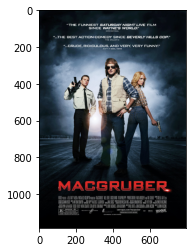

In [32]:
plt.imshow(image)
plt.show()

In [33]:
text = pytesseract.image_to_string(image)
print(text)

“THE FUNNIEST SATURDAY NIGHT LIVE FILM
SINGE WAYNE’S WORLD”

“THE BEST AGCTION-COMEDY SINCE BEVERLY HILLS COP.”

qe] US, AND VERY, VERY FUNNY.”
Doo

rlelElrblly fag ae
rrr

 



Awesome!! We are in business with our Optical Character Recognition now.  Although it is not perfect, it should work for our purposes.  Let's feed it into the predictor to see what it thinks of those comments!

In [34]:
predictor.predict(text)

'pos'

Amazing!!! Now let's just package that up into a function for ease of use :)

In [35]:
def make_prediction(predictor, text):
  prediction = predictor.predict(text)
  return prediction

def run_ocr(img_path):
  image = Image.open(img_path)
  text = pytesseract.image_to_string(image)
  plt.imshow(image)
  plt.show()
  return text

def ocr_sentiment_predictor(predictor, images):
  for img in images:
    text = run_ocr(img)
    print(f'Extracted Text: \n{text}\n')
    prediction = make_prediction(predictor,text)
    print(f'Sentiment Prediction: {prediction}\n')

In [36]:
test_path1 = drive_path+'test_images/avatar.jpeg'
test_path2 = drive_path+'test_images/macgruber.jpeg'
images = [test_path1, test_path2]

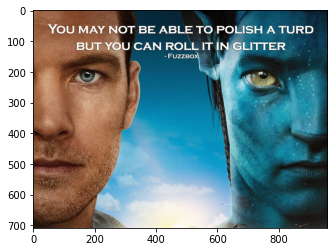

Extracted Text: 
Nor MAY NOT BE ABLE TO POLISH A TURD
U CAN tele. ny I

   


Sentiment Prediction: neg



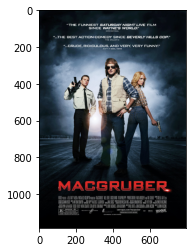

Extracted Text: 
“THE FUNNIEST SATURDAY NIGHT LIVE FILM
SINGE WAYNE’S WORLD”

“THE BEST AGCTION-COMEDY SINCE BEVERLY HILLS COP.”

qe] US, AND VERY, VERY FUNNY.”
Doo

rlelElrblly fag ae
rrr

 


Sentiment Prediction: pos



In [37]:
# NOTE - these reviews are not my own :) 
ocr_sentiment_predictor(predictor, images)

Let's do one final test, let's see how the model handles a handwritten review.

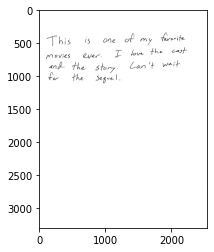

Extracted Text: 
7 his Is One of My duverife
(Movies eye. L love the cast

ANG The Ste Lan t WAIT
ory . .
Cae the Jegve | .


Sentiment Prediction: pos



In [38]:
ocr_sentiment_predictor(predictor,['/content/drive/MyDrive/NLP/test_images/handwritten_review.jpg'])

Well..kind of lol it struggled with my horrible handwriting, which is to be expected, but did extract enough to know it was a positive review (likely keyed in on the 'love the cast' portion).  This model could be improved by further training on handwritten images, but for now we will call this a win!

## Wrap-Up ##

This has been really fun.  We started by just playing around with different deep learning networks best suited to handle the nuance of the English language and really took off from there, bringing in **transfer learning with BERT and ktrain** as well as **optical character recognition with pytesseract**.  Improved a baseline model from 81% to 95% and built a fun interactive function to cap it off.  All told the notebook takes about 5.2 hours to run, once again not bad for a days work!

In [39]:
notebook_end = time.time()

notebook_runtime_seconds = notebook_end - notebook_start
notebook_runtime_minutes = notebook_runtime_seconds / 60
notebook_runtime_hours = notebook_runtime_minutes / 60

print(f'> Notebook Total Run Time: {notebook_runtime_minutes} minutes ({notebook_runtime_hours} hours')

> Notebook Total Run Time: 310.52734534343085 minutes (5.175455755723847 hours
